# Switching Recurrent Neural Networks (SRNNs) Tutorial on Lorenz Attractor

### Step 1: Package load
In this step, we load the packages of SRNNs. **Please note** the initializatins are very important to SRNNs as well as other SSM models to shorten training time and avoid stuck of training as we discussed in our paper. If you use HMM as a initialization, you have two options:
<br>
(1) We provide HMM package from Linderman SSM, you may **import ssm** to test whether the SSM package is installed. If so, you can specify the initialization method to be 'hmm' in step 5.
<br>
(2) If the ssm doesn't work for you or you would like to use your own initialization (e.g., your own HMM, your own labels, etc.), please change the initialization method to be 'defined'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from SRNN import model_srnn
from SRNN import inference_network
from SRNN import initialization
from SRNN import train
from SRNN import generative_check
from sklearn.metrics import mean_squared_error

np.random.seed(131)
torch.manual_seed(131)

#### If you would like to test SRNNs with your own data, please change the 'y_c' in Step 2, 'num_tv' and 'hidden_shape' in Step 3. The visualization depends on your data, so you may delete the visualization of the dataset to run this notebook. Please note that other hyper parameters may also need to change to get good results.

### Step 2: Data load
In this step, we load and visualize the data of lorenz attractor. You may change this 'y_c' to your own data, the data has to be in size of

__(#samples*#time points*#features)__.

In [2]:
y_c=np.load('./data/lorenz_new.npy') # (#samples*#time points*#features)

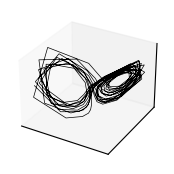

In [3]:
# Let's visualize one trial of lorenz attractors.
ax = plt.figure(figsize=(2,2)).add_subplot(projection='3d')
ax.plot(y_c[0,:,0],y_c[0,:,1],y_c[0,:,2], lw=0.5,color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

We then split the data into training and testing, i.e., 17 trials in training and 1 trials in testing. 'jobid' is to set which trial in testing.

In [4]:
jobid=0 # set first trial to be validation, the rest of trials to be training.
train_data=np.delete(y_c,(int(jobid)),axis=0)
test_data=y_c[int(jobid):int(jobid)+1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
X_train=torch.tensor(0*train_data,dtype=dtype,device=device)
y_train=torch.tensor(train_data,dtype=dtype,device=device)
y_test=torch.tensor(test_data,dtype=dtype,device=device)
X_test=torch.tensor(0*test_data,dtype=dtype,device=device)
### beh_all_train and beh_all_test are behavioral labels, we don't have to use them in lorenz attractor.
beh_all_train=None
beh_all_test=None

### Step 3: Hyperparameters

In [5]:
input_shape=X_train.shape[2] # Input shape of SRNNs, but the models are input free.
num_tv=2 # Number of RNNs in SRNNs.
hidden_shape=3 # Number of hidden states of SRNNs.
ini_epochs=3000 # Epochs in initialization stage, can be longer than training stage.
coef_cross=5e-1 # Coefficient of initialization, larger coef_cross means larger constraint on posterior states in initialization. 
epochs=2000 # Epochs in training stage.
lr=0.001 # Learning rate

### Step 4: Define SRNN and Inference Networks

In [6]:
model = model_srnn.Model(input_shape,num_tv,hidden_shape).to(device)
rnninfer=inference_network.RNNInfer(input_shape,hidden_shape).to(device)

In [7]:
print(model);print(rnninfer)

Model(
  (rnns): ModuleList(
    (0-1): 2 x RNN(3, 3, batch_first=True)
  )
  (emission): Emission(
    (fc1): Linear(in_features=3, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=3, bias=True)
    (relu): ReLU()
  )
  (transitions): RNNCell(3, 4)
)
RNNInfer(
  (forward_rnn): RNN(3, 3, batch_first=True)
  (backward_rnn): RNN(3, 3, batch_first=True)
  (rnn_mean): RNN(3, 3, batch_first=True)
  (lc1): Linear(in_features=6, out_features=64, bias=True)
  (lc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)


### Step 5: Initialization

In [8]:
optimizer = torch.optim.Adam(list(model.parameters())+list(rnninfer.parameters()) ,lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)


In [9]:
model_ini,rnninfer_ini,mse_all_ini,error_all_ini,mse_all_test_ini,error_all_test_ini,loss_all_ini,pos_test_all_ini=initialization.run(model,
                                                                                                                     rnninfer,
                                                                                                                     optimizer,
                                                                                                                     scheduler,
                                                                                                                     X_train,
                                                                                                                     y_train,
                                                                                                                     X_test,
                                                                                                                     y_test,
                                                                                                                     beh_all_train,
                                                                                                                     beh_all_test,
                                                                                                                     num_tv,
                                                                                                                     coef_cross,
                                                                                                                     ini_epochs,
                                                                                                                     device,
                                                                                                                     method='hmm',
                                                                                                                     t_load=None)

C:\Users\yongx\anaconda3\envs\myssm\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/3000, loss = 57437707.17940587
Epoch 101/3000, loss = 14613548.857266843
Training Still Needs :- 00d01h45m19s  (Estimated).
Epoch 201/3000, loss = 7850850.695230514
Training Still Needs :- 00d01h42m59s  (Estimated).
Epoch 301/3000, loss = 3727368.3735957593
Training Still Needs :- 00d01h39m28s  (Estimated).
Epoch 401/3000, loss = 823333.4744230509
Training Still Needs :- 00d01h35m51s  (Estimated).
Epoch 501/3000, loss = 361338.1814042353
Training Still Needs :- 00d01h32m13s  (Estimated).
Epoch 601/3000, loss = 215241.97308680415
Training Still Needs :- 00d01h28m34s  (Estimated).
Epoch 701/3000, loss = 149159.2683597803
Training Still Needs :- 00d01h24m53s  (Estimated).
Epoch 801/3000, loss = 126856.3676404953
Training Still Needs :- 00d01h21m13s  (Estimated).
Epoch 901/3000, loss = 84380.13920673728
Training Still Needs :- 00d01h17m27s  (Estimated).
Epoch 1001/3000, loss = 64481.979630321264
Training Still Needs :- 00d01h13m38s  (Estimated).
Epoch 1101/3000, loss = 49889.264642

Now, we can test the SRNN after initialization.

In [10]:
y_pred_test_ini,pos_test_ini,sampled_h_test_ini=train.eval_(model_ini,rnninfer_ini,X_test,y_test,device)

#### We also include another tutorial using 'random' initailization, SRNNs are also able to identify correct states.

### Step 6: Training

In [11]:
model_trained,rnninfer_trained,mse_all_train,error_all_train,mse_all_test,error_all_test,loss_all_test,pos_test_all=train.train_(model_ini,
                                                                                                                    rnninfer_ini,
                                                                                                                    optimizer,
                                                                                                                    scheduler,
                                                                                                                    X_train,
                                                                                                                    y_train,
                                                                                                                    X_test,
                                                                                                                    y_test,
                                                                                                                    beh_all_train,
                                                                                                                    beh_all_test,
                                                                                                                    num_tv,
                                                                                                                    epochs,
                                                                                                                    device)

Epoch 1/2000, loss = -39365.91796875
Epoch 101/2000, loss = -41225.76953125
Training Still Needs :- 00d01h07m52s  (Estimated).
Epoch 201/2000, loss = -43329.01953125
Training Still Needs :- 00d01h04m18s  (Estimated).
Epoch 301/2000, loss = -45128.9140625
Training Still Needs :- 00d01h00m38s  (Estimated).
Epoch 401/2000, loss = -42540.87109375
Training Still Needs :- 00d00h56m50s  (Estimated).
Epoch 501/2000, loss = -47569.49609375
Training Still Needs :- 00d00h53m25s  (Estimated).
Epoch 601/2000, loss = -48445.8046875
Training Still Needs :- 00d00h49m57s  (Estimated).
Epoch 701/2000, loss = -47782.2890625
Training Still Needs :- 00d00h46m24s  (Estimated).
Epoch 801/2000, loss = -36859.52734375
Training Still Needs :- 00d00h42m56s  (Estimated).
Epoch 901/2000, loss = -50839.796875
Training Still Needs :- 00d00h39m31s  (Estimated).
Epoch 1001/2000, loss = -21477.42578125
Training Still Needs :- 00d00h35m57s  (Estimated).
Epoch 1101/2000, loss = -52306.23828125
Training Still Needs :- 00d

Now, we can test the SRNN after training.

### Step 7: Analysis

In [12]:
y_pred_test,pos_test,sampled_h_test=train.eval_(model_trained,rnninfer_trained,X_test,y_test,device)

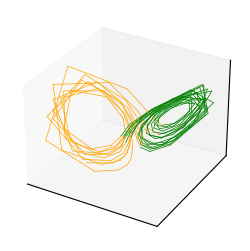

In [13]:
# Let's visualize.
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_pred_test[0])-2):
    ax.plot(y_pred_test[0,i:i+2,0],y_pred_test[0,i:i+2,1],y_pred_test[0,i:i+2,2], lw=0.5,color=color_list[int(np.argmax(pos_test[0],axis=1)[i])])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

Now, check validation loss and MSE of training.

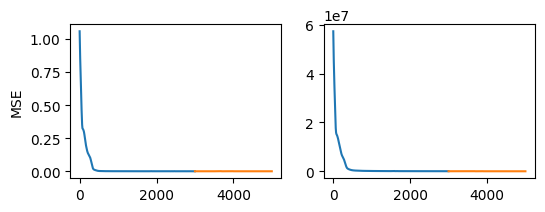

In [14]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],mse_all_test_ini)
plt.plot(plot_epoch[ini_epochs:],mse_all_test)
plt.ylabel('MSE')
plt.subplot(1,2,2)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],loss_all_ini)
plt.plot(plot_epoch[ini_epochs:],loss_all_test)
plt.show()

Now, let's test whether the generative model works and can generate right trajectory using inferred discrete states.

In [15]:
generative_y_test,generative_h=generative_check.run(model,rnninfer,X_test,y_test,pos_test,device)

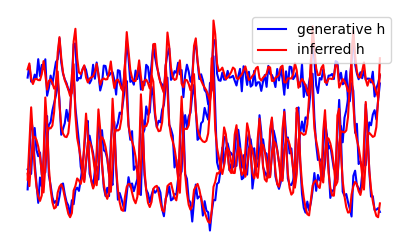

In [16]:
plt.figure(figsize=(5,3))
lines=plt.plot(generative_h,color='blue',label='generative h')
plt.setp(lines[1:],label='_')
lines=plt.plot(sampled_h_test[0],color='red',label='inferred h')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

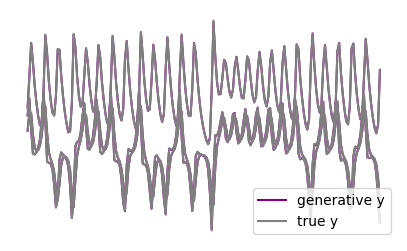

In [17]:
plt.figure(figsize=(5,3))
lines=plt.plot(y_pred_test[0],color='purple',label='generative y')
plt.setp(lines[1:],label='_')
lines=plt.plot(y_test.cpu().detach().numpy()[0],color='gray',label='true y')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

Now, let's look at how states identified by SRNNs change across epochs.

In [18]:
state_all_ini=[]
for i in range(ini_epochs):
    state_all_ini.append(np.argmax(pos_test_all_ini[i,0,:,:],axis=1))
state_all_ini=np.array(state_all_ini)

state_all=[]
for i in range(epochs):
    state_all.append(np.argmax(pos_test_all[i,0,:,:],axis=1))
state_all=np.array(state_all)

state_entire=np.vstack((state_all_ini,state_all))

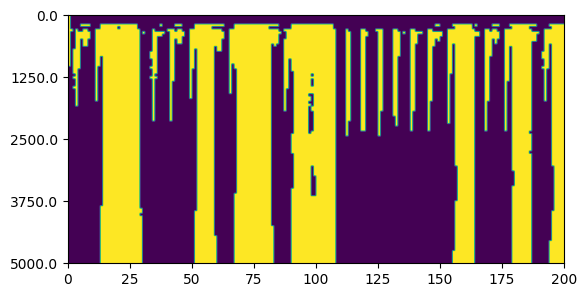

In [19]:
fig, ax = plt.subplots(1,1)
l=int(state_entire.shape[0]/100)
state_show=state_entire[0:1]
for i in range(100):
    state_show=np.vstack((state_show,state_entire[i*l+l:i*l+l+1]))
ax.imshow(state_show,extent=[0,state_show.shape[1],state_entire.shape[0]/l,0])
y_label_list = list(np.linspace(0,state_entire.shape[0],5))
ax.set_yticks(list(np.linspace(0,state_show.shape[0],5)))
ax.set_yticklabels(y_label_list)
plt.show()